In [2]:
# Codice per clonare la repository di github con tutti i dati. Va eseguito una sola volta
# (per questo si controlla se la cartella esista già o meno)
# È stato scelto questo metodo per permettere a tutti, sia da google colab che in locale,
# di avere i dati a disposizione

# Se si esegue in locale, assicurarsi di avere git installato
# Al link della repository sono visionabili tutti i file
from os import path
if not path.exists("Laboratorio_Fisica_3"):
    !git clone https://github.com/MasterRoby3/Laboratorio_Fisica_3

# Per comodità si definisce una variabile che sia la radice di tutti i percorsi utilizzati, in modo da alleggerire il codice successivo
rad = "Laboratorio_Fisica_3/Assorbanza/"

# In questa prima cella si importano anche le librerie necessarie:
import numpy as np
from scipy import optimize as sop
from scipy import constants as scc
import matplotlib.pyplot as plt
import pandas as pd

#Altri dati utili per i plot
titlefontsize, labelfontsize, tickfontsize=20, 16, 14
markersize, linewidth = 6, 1

# Assorbanza: esperienza sull'assorbimento e verifica della legge di Lambert-Beer

Lo scopo di questa esperienza è verificare la legge di Lambert Beer sull'assorbimento della luce emessa da LED di vari colori. A questo scopo si utilizza un apparato sperimentale composto di vari foglietti colorati (rossi, gialli e blu) e vari LED colorati (rossi, gialli, verdi e blu). I foglietti vengono posti poi tra due placchette di plexiglass trasparenti tenute insieme da una molletta; si dispone il tutto secondo lo schema in figura (fonte: slide di laboratorio):

<br><center><img src="Laboratorio_Fisica_3/Assorbanza/img/assorbanza.png" width="750"/></center><br>

La legge di Lambert-Beer da verificare con i dati raccolti è la seguente:
$$I = I_0 e^{-\alpha n} + I_b$$
Dove:
* $I$ è l'intensità della luce
* $\alpha$ è il coefficiente di assorbimento moltiplicato per lo spessore di un foglietto
* $n$ è il nuero di foglietti
* $I_0$ è l'intensità trasmessa in assenza di foglietti (intensità di riferimento, con le sole placchette di plexiglass)
* $I_b$ è l'intensità di fondo

Inoltre, la trasmittanza è definita come $T = \frac{I}{I_0}$ da cui, prendendo il logaritmo, si ottiene $\ln T = -\alpha n$

In questa esperienza, come nell'esperienza sulla collimazione delle lenti e in quella sulla caratterizzazione ottica del diodo, si è fatto uso di una scatoletta nera a batterie che polarizzi inversamente il fotodiodo in modo da ottenere una risposta lineare rispetto all'intensità ricevuta: $V_{ph} \propto I$. Le misure di intensità vengono quindi effettuate in tensione (si farà riferimento quindi a $V$, $V_0$ e $V_b$ più che a $I$, $I_0$ e $I_b$).

I LED utilizzati vengono alimentati in onda quadra (rosso e giallo a 6 V picco-picco, mentre blu e verde a 7 V): ciò viene fatto allo scopo di distinguere il segnale dal fondo luminoso, misurando l'ampiezza dell'onda quadra ricevuta dal fotodiodo con un oscilloscopio.

NOTA: la tensione di riferimento senza foglietti è stata rimisurata ogni volta che si è cambiato il numero di foglietti, questo allo scopo di minimizzare l'errore dovuto alle piccole fluttuazioni tra una serie di misure e l'altra

In [7]:
# Qui si definiscono le funzioni utili per il fit
def lambert_beer(n , alfa, V_b, V_0):
    return V_0 * np.exp(-alfa * n) + V_b

# Funzione utile per il calcolo dell'R^2
def r_squared(actual, predicted):
    residuals = actual - predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum( (actual - np.mean(actual))**2 )
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

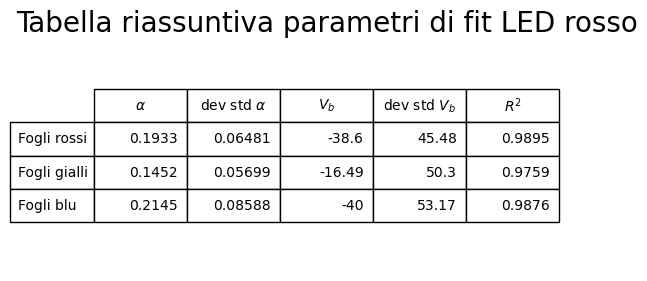

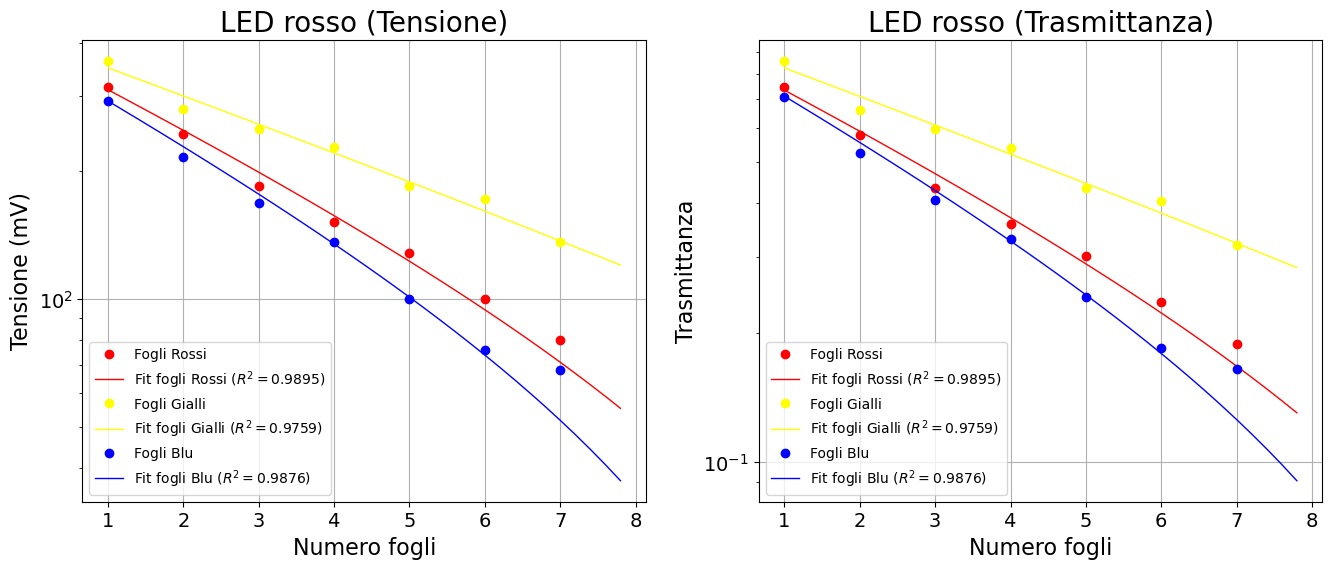

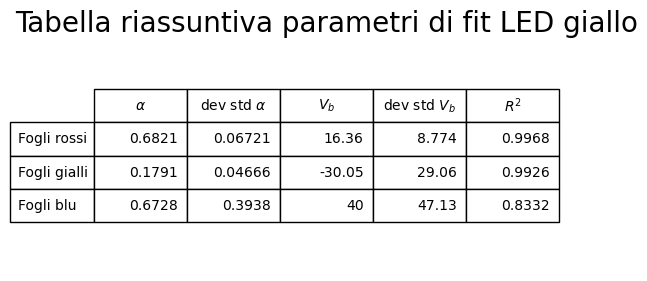

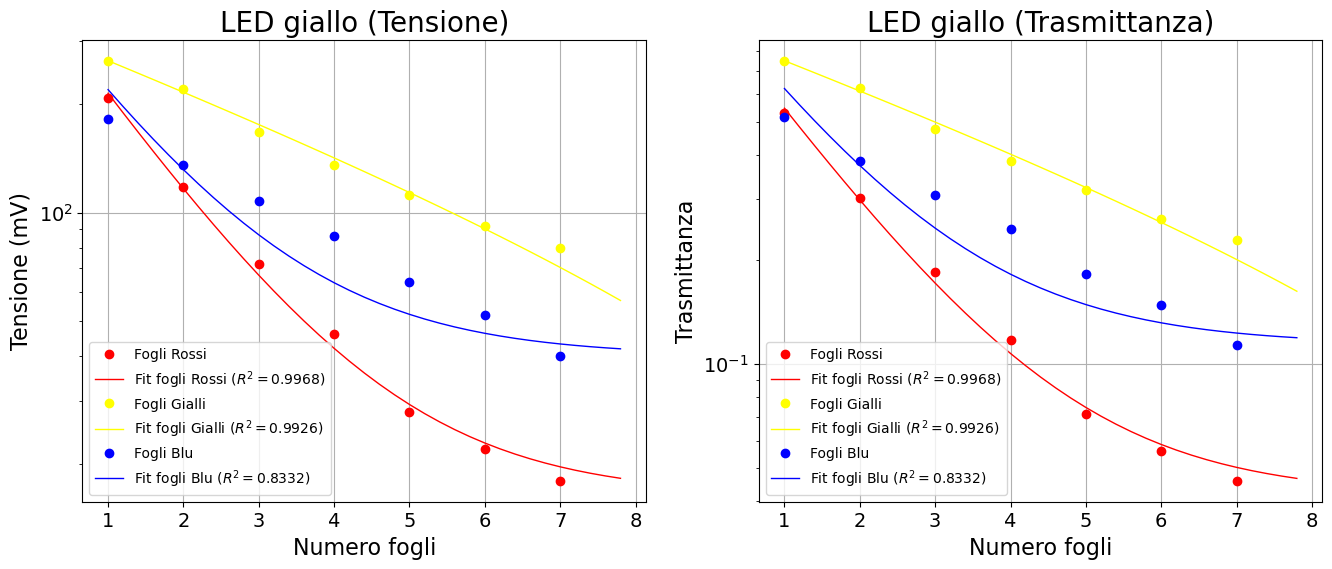

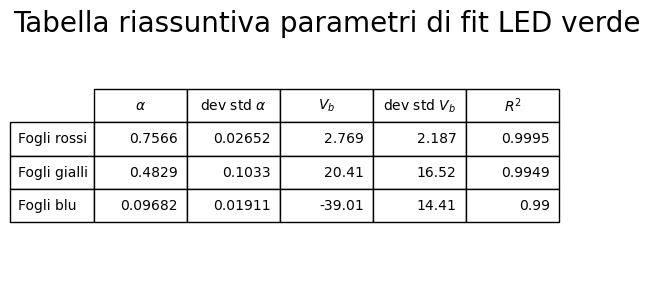

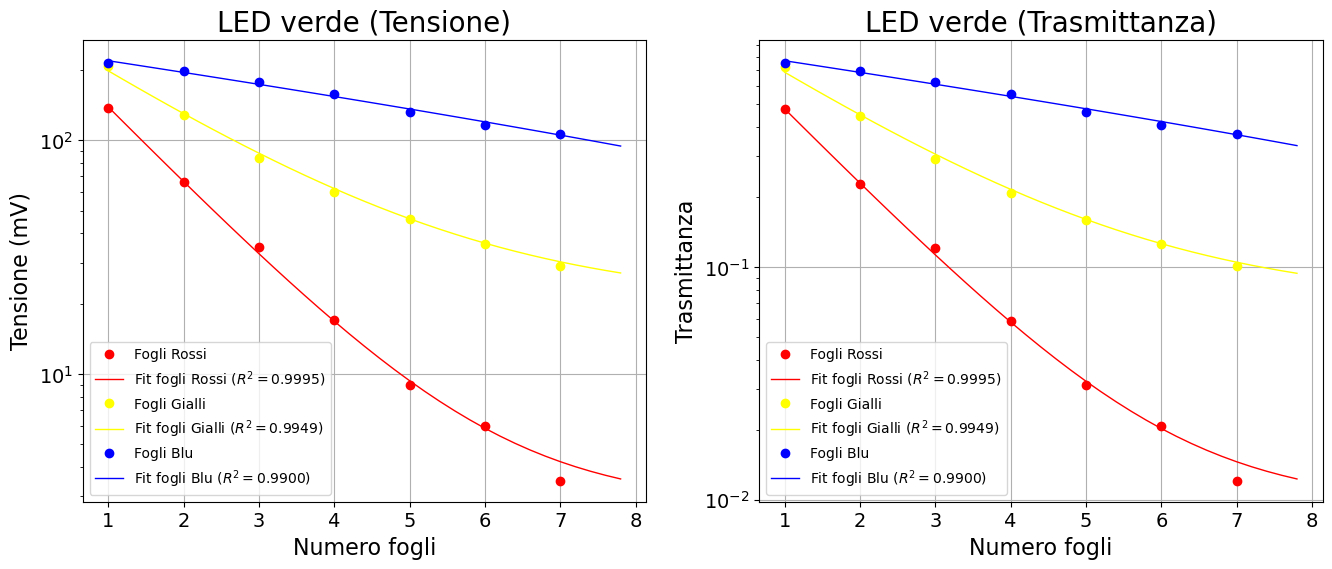

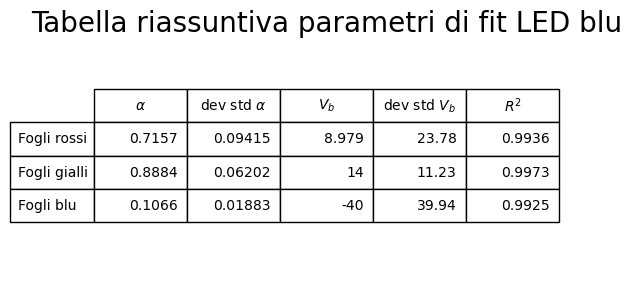

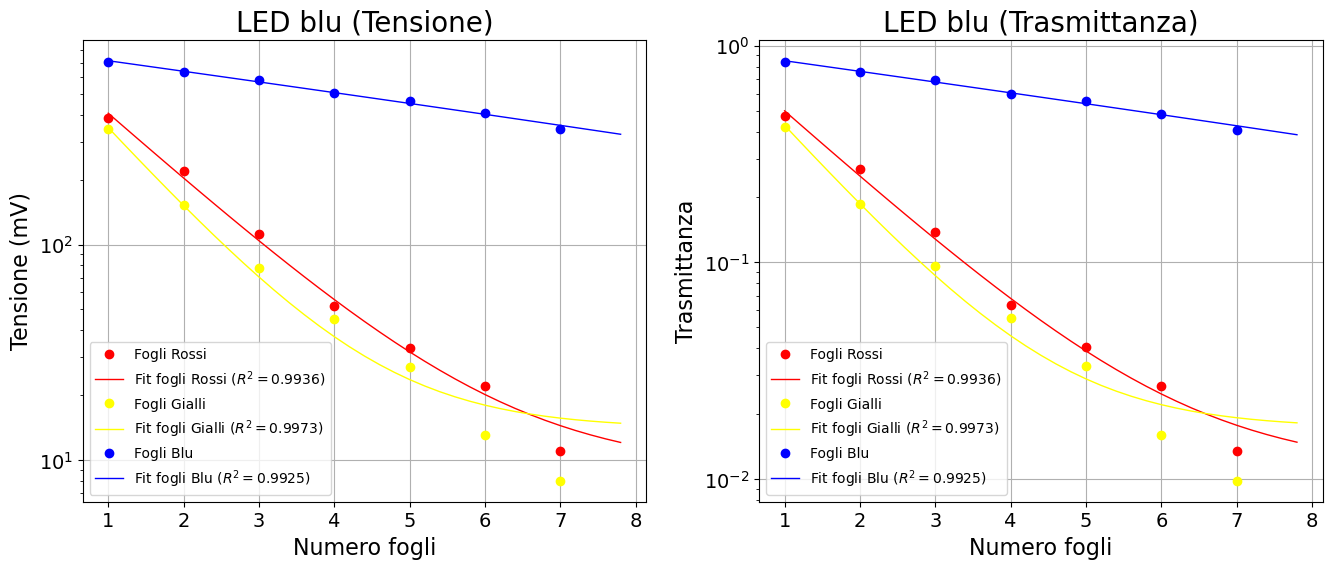

In [62]:
# Per snellire il codice e agevolare la procedura, verrà effettuato un ciclo sui led che per ogni led:
# - legge il file csv con i dati
# - visualizza i dati
# - plotta i dati con la legge fittata
leds = ["rosso", "giallo", "verde", "blu"]

for led_color in leds:
    # Lettura dati da csv
    data = pd.read_csv(rad + "data/led_" + led_color + ".csv")
    headers = data.keys()

    # numpy array per il numero di fogli
    n = data['n'].to_numpy()

    # si crea un dizionario per immagazzinare i dati di tensione usando il colore dei fogli come chiave
    # gli array numpy contenuti nel dizionario sono ordinati in numero incrementale di fogli
    V_dict = {
        "Rossi":data['V_rossi'].to_numpy(),
        "Gialli":data['V_gialli'].to_numpy(),
        "Blu":data['V_blu'].to_numpy()
    }

    # Fit
    # I risultati si salvano in un altro dizionario con la stessa struttura del precedente
    # La lista salvata contiene, nell'ordine: alfa, dev std di alfa, V_b, dev std di V_b, R^2
    fit_results = {
        "Rossi":[0,0,0,0,0],
        "Gialli":[0,0,0,0,0],
        "Blu":[0,0,0,0,0]
    }

    # Si definiscono dei bounds comuni per i fit
    alfa_min, alfa_max = 0., 5
    V_b_min, V_b_max = -40, 40
    min, max = [alfa_min, V_b_min], [alfa_max, V_b_max]
    bounds = [min, max]

    # si cicla sulle misure dei vari foglietti per fare i fit
    for key, V in V_dict.items():
        # Si salva il primo parametro del vettore V come V_0 (misura con 0 foglietti) e si rimuove dal vettore per il fit
        V_0 = V[0]
        V_red = V[1:]
        n_red = n[1:]   # si riduce anche il vettore n
        ndata = len(V)

        # Si procede con il fit
        # come fatto in altre relazioni, si usa una lambda function per fissare il valore di V_0 e fittare solo alfa e V_b
        popt, pcov = sop.curve_fit(lambda n, alfa, V_b: lambert_beer(n, alfa, V_b, V_0), n_red, V_red, bounds=bounds)
        alfa = popt[0]
        V_b = popt[1]

        # Si effettua la seguente operazione per ottenere la deviazione standard e non lo standard error
        sigma = np.sqrt(ndata*np.diag(pcov))
        r_sq = r_squared(V_red, lambert_beer(n_red, alfa, V_b, V_0))

        # Stampa dei parametri di fit ottenuti, commentato in favore della tabella più esplicativa e migliore da vedere
        # print('\nFogli', key + ':\tValore fittato per alfa=', "{:.3g}".format(alfa), 'deviazione standard=',"{:.3g}".format(sigma[0]), "\n\t\tValore fittato per V_b: ", "{:.3g}".format(V_b), 'deviazione standard=',"{:.3g}".format(sigma[1]), "\n\t\tR^2 = ", "{:.5g}".format(r_sq))
        fit_results[key] = [alfa, sigma[0], V_b, sigma[1], r_sq]

    # Tabella
    figure = plt.figure(figsize=[6,3])
    plt.title("Tabella riassuntiva parametri di fit LED "+led_color, size=titlefontsize)
    plt.axis('tight')
    plt.axis('off')
    rows = ["Fogli rossi", "Fogli gialli", "Fogli blu"]
    columns = [r"$\alpha$", r"dev std $\alpha$", "$V_b$", "dev std $V_b$", "$R^2$"]
    table_data = [["{:.4g}".format(s) for s in l] for l in list(fit_results.values())]
    table = plt.table(cellText=table_data, colLabels=columns, rowLabels=rows, loc='center')
    table.set_fontsize(14)
    table.scale(1, 2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,6])
    ax1.set_yscale("log")
    ax1.set_title('LED ' + led_color + ' (Tensione)' , size=titlefontsize)
    ax2.set_yscale("log")
    ax2.set_title('LED ' + led_color + ' (Trasmittanza)', size=titlefontsize)

    n_fit = np.arange(1.,8.,0.2)
    for key, V in fit_results.items():
        # si determina il colore per i plot dalla chiave, che rappresenta il colore dei fogli
        color = "black"
        if key == "Rossi":
            color = "red"
        elif key == "Gialli":
            color = "yellow"
        else:
            color = "blue"

        ax1.plot(n[1:], V_dict[key][1:], 'o', markersize=markersize, color=color, label="Fogli "+key)
        ax1.plot(n_fit, lambert_beer(n_fit, fit_results[key][0], fit_results[key][2], V_dict[key][0]), linewidth=linewidth, color=color, label="Fit fogli "+key+" ($R^2=${:.4f})".format(fit_results[key][4]))
        ax2.plot(n[1:], V_dict[key][1:]/V_dict[key][0], 'o', markersize=markersize, color=color, label="Fogli "+key)
        ax2.plot(n_fit, lambert_beer(n_fit, fit_results[key][0], fit_results[key][2], V_dict[key][0])/V_dict[key][0], linewidth=linewidth, color=color, label="Fit fogli "+key+" ($R^2=${:.4f})".format(fit_results[key][4]))


    ax1.set_xlabel('Numero fogli', size=labelfontsize)
    ax1.set_ylabel('Tensione (mV)', size=labelfontsize)
    ax1.tick_params(labelsize=tickfontsize)
    ax1.grid(True)
    ax1.legend()

    ax2.set_xlabel('Numero fogli', size=labelfontsize)
    ax2.set_ylabel('Trasmittanza', size=labelfontsize)
    ax2.tick_params(labelsize=tickfontsize)
    ax2.grid(True)
    ax2.legend()

I risultati ottenuti sono da ritenersi soddisfacenti: le imprecisioni di alcuni fit possono essere attribuibili a vari tipi di imprecisioni, tra cui la disuniformità delle dimensioni dei foglietti utilizzati.
Dai grafici (e dai valori del parametro $\alpha$) si nota il comportamento atteso: escluso il caso di fogli gialli con LED rosso, si nota che in media i fogli dello stesso colore del LED trasmettono meglio di quelli di colore diverso; questo effetto è particolarmente visible con il LED blu e il verde (che si comporta similmente al blu, avendo i fogli rossi che assorbono parecchio)